In [1]:
# import sys
# sys.path.insert(0, 'visualization.py')
# sys.path.insert(0, 'utils.py')

In [1]:
# /!\ Before running the lab make sure every additional libraries is installed 

# Import local libraries
from visualization import *
from utils import *


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Task n°1


This exercise is about showing measurements made by the Intelligent Road-Side Unit (IRSU) positioned at the center of the intersection:
- 1 point clouds collected by a 32-channel LiDAR

The functions you need to modify are located in:
-  box_to_corner -> visualization.py

-  get_boxes_in_actor_frame -> utils.py

In [2]:
n_frame = 0
actor = 'ego_vehicle'
#actor = 'other_vehicle'
#actor = 'other_vehicle_behind'                 #Problem in the rotation matrix -> not possible compute quaternion not orthogonal then computed yaw directly
#actor = 'infrastructure'

irsu_points = get_point_cloud(n_frame, actor)
irsu_boxes = get_boxes_in_actor_frame(n_frame, actor)
box_colors = CLASS_COLORS[irsu_boxes[:, -1].astype(np.int32)]# this is just a dummy value
show_objects(irsu_points[:,:3], irsu_boxes[:,:7], box_colors)

# Task n°2

This exercise demonstrates how the field of view and perception range of a vehicle can be enhanced by receiving data from other vehicles and the IRSU.

The functions you need to modify are:
-  box_to_corner (already done in task 1) -> visualization.py
-  get_available_point_clouds, get_available_boxes_in_ego_frame, get_boxes_in_actor_frame(already done in task 1) -> utils.py

In [3]:
n_frame = 0
actors = ["ego_vehicle" ,"other_vehicle",   "ego_vehicle_behind","other_vehicle_behind" ,"infrastructure",]  #ego_vehicle_behind has not a correct transformation Matrix-> directly yaw
#actors = ["ego_vehicle" ,"other_vehicle","other_vehicle_behind" ,"infrastructure",]    Possible using quaternions
merged_points = get_available_point_clouds(n_frame, actors)
irsu_boxes = get_available_boxes_in_ego_frame(n_frame, actors)
box_colors = CLASS_COLORS[irsu_boxes[:, -1].astype(np.int32)]

show_objects(merged_points, irsu_boxes[:,:7], box_colors)

# Task n°3

Build a BEV occupancy grid of the environment

A main challenge in perception on point clouds is their unordered nature which hinders the application of the Convolution operation, thus preventing the use of many wonders in the world of image-based perception. An effective way to get around this challenge is to convert point clouds to BEV images. In other word, to look at a point cloud from the top-view which is what you are going to do in this exercise.

The functions you need to modify are :
-  box_to_pixels, points_to_pixels-> visualization.py
-  filter_points -> utils.py

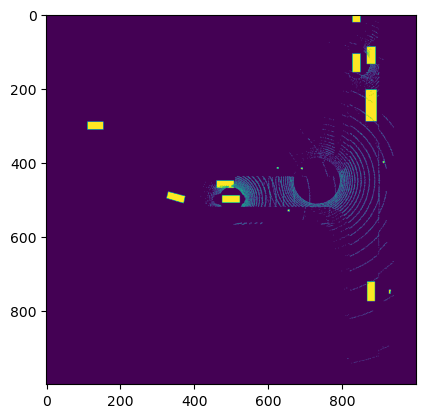

In [4]:

n_frame = 0
#actors = ["ego_vehicle" ,"other_vehicle",   "ego_vehicle_behind","other_vehicle_behind","infrastructure",] #ego_vehicle_behind has not a correct transformation Matrix
actors = ["ego_vehicle" ,"other_vehicle","other_vehicle_behind","infrastructure",]
merged_points = get_available_point_clouds(n_frame, actors)
irsu_boxes = get_available_boxes_in_ego_frame(n_frame, actors)
box_colors = CLASS_COLORS[irsu_boxes[:, -1].astype(np.int32)]

# ------------------    print (pixels.shape)Get Waypoints that belongs to the ground floor ------------------
points_range = np.array([-50, -50, -25, 50, 50, 0.01])  # xmin, ymin, zmin, xmax, ymax, zmax (meters) around ego_vehicle
filtered_points = filter_points(merged_points, points_range)
show_objects(filtered_points, irsu_boxes[:,:7], box_colors)

# ------------------  Build BEV image  ------------------  
bev_resolution = 0.1 # meters / pixel
bev_imsize = np.ceil((points_range[3: 5] - points_range[:2]) / bev_resolution).astype(int)  # (width, height)
bev_occupancy = np.zeros((bev_imsize[1], bev_imsize[0]))



# ------------------  Project bbox of actors on the image------------------  
for i in range(irsu_boxes.shape[0]):
    box_mask = box_to_pixels(irsu_boxes[i:i+1, :7], bev_imsize, bev_resolution)
    bev_occupancy[box_mask > 0] = 255

# ------------------Project navigable space on the image------------------  
navigable_space = points_to_pixels(filtered_points, bev_imsize, bev_resolution)
for pixel in navigable_space:
    bev_occupancy[round(pixel[1]), round(pixel[0])] = 150

plt.imshow(bev_occupancy)


# Task n°4: 
Segment points according to object's class

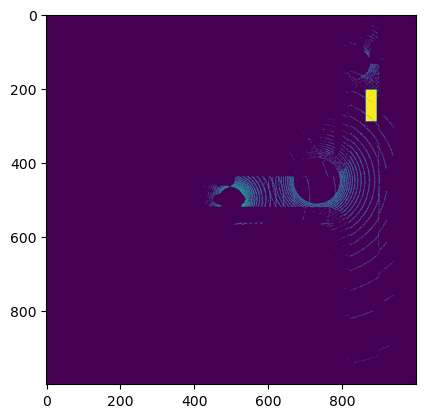

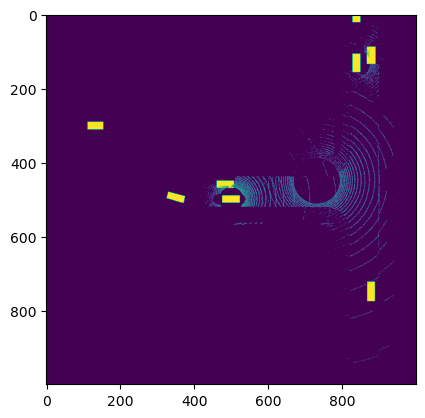

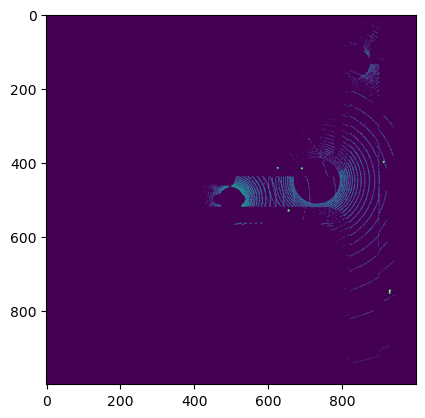

In [5]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Function to update the value of 'method' based on the button pressed
def update_method(button):
    global method
    method = button.description
    boxes = detection_obj(n_frame,actors,method)
    box_colors = CLASS_COLORS[boxes[:, -1].astype(np.int32)]
# ------------------    print (pixels.shape)Get Waypoints that belongs to the ground floor ------------------
    points_range = np.array([-50, -50, -25, 50, 50, 0.01])  # xmin, ymin, zmin, xmax, ymax, zmax (meters) around ego_vehicle

    filtered_points = filter_points(merged_points, points_range)
    show_objects(filtered_points, boxes[:,:7], box_colors)
    # ------------------  Build BEV image  ------------------  
    bev_resolution = 0.1 # meters / pixel
    bev_imsize = np.ceil((points_range[3: 5] - points_range[:2]) / bev_resolution).astype(int)  # (width, height)
    bev_occupancy = np.zeros((bev_imsize[1], bev_imsize[0]))

    # ------------------  Project bbox of actors on the image------------------  
    for i in range(boxes.shape[0]):
        box_mask = box_to_pixels(boxes[i:i+1, :7], bev_imsize, bev_resolution)
        bev_occupancy[box_mask > 0] = 255

    # ------------------Project navigable space on the image------------------  
    navigable_space = points_to_pixels(filtered_points, bev_imsize, bev_resolution)
    for pixel in navigable_space:
        bev_occupancy[round(pixel[1]), round(pixel[0])] = 150

    plt.imshow(bev_occupancy)

# Create setting for buttons
button_layout = widgets.Layout(width='200px', height='50px')
button_style_truck = {'button_color': '#3498db', 'font_weight': 'bold', 'font_size': '12pt'}
button_style_car = {'button_color': '#8e44ad', 'font_weight': 'bold', 'font_size': '12pt'}
button_style_pedestrians = {'button_color': '#ff4136', 'font_weight': 'bold', 'font_size': '12pt'}
button_style_motorcycle = {'button_color': '#FFD700', 'font_weight': 'bold', 'font_size': '12pt'}
button_style_all = {'button_color': '#2ecc71', 'font_weight': 'bold', 'font_size': '12pt'}

# Define the buttons
truck_button = widgets.Button(description='Truck', layout=button_layout, style=button_style_truck)
car_button = widgets.Button(description='Car', layout=button_layout, style=button_style_car)
pedestrians_button = widgets.Button(description='Pedestrians', layout=button_layout, style=button_style_pedestrians)
motorcycle_button = widgets.Button(description='Motorcycle', layout=button_layout, style=button_style_motorcycle)
all_button = widgets.Button(description='All', layout=button_layout, style=button_style_all)

# Define the title
title = widgets.Label(value='Select Object Type:', style={'font_size': '14pt'})

# Assign the same callback function to all buttons
truck_button.on_click(update_method)
car_button.on_click(update_method)
pedestrians_button.on_click(update_method)
motorcycle_button.on_click(update_method)
all_button.on_click(update_method)

# Display buttons
button_box = widgets.HBox([truck_button, car_button, pedestrians_button, motorcycle_button, all_button])
display(widgets.VBox([title, button_box]))
method = None

